In [1]:
import math
import numpy as np
import numpy.random as nr
from sklearn.svm import SVC
from sklearn.decomposition import PCA
from sklearn.metrics import classification_report
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix
from __future__ import print_function
from time import time
import logging
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

# PCA (Tutorial)

http://scikit-learn.org/stable/auto_examples/applications/face_recognition.html

In [2]:
X, y = np.load('X_train.npy'), np.load('y_train.npy')

Z = np.load('X_test.npy')

n_samples, h, w = X.shape[0], 50, 37
target_names = range(7)
n_classes = 7

In [3]:
def pca_fit(X, n_components = 150):
    t0 = time()
    pca = PCA(n_components=n_components, svd_solver='randomized',
              whiten=True).fit(X)
    print("done in %0.3fs" % (time() - t0))
    return pca

In [42]:
def pca_grid_search_svm(X, y, n_components = 150, random_state = 3244):
    
    # validation set
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.25, random_state=random_state)
    
    pca = pca_fit(X_train, n_components=n_components)
    
    # tranform train and test data
    print("Projecting the input data on the eigenfaces orthonormal basis")
    t0 = time()
    X_train_pca = pca.transform(X_train)
    X_test_pca = pca.transform(X_test)
    print("done in %0.3fs" % (time() - t0))
    
    # grid search to tune hyper-paramters
    print("Fitting the classifier to the training set")
    t0 = time()
    param_grid = {'C': [1, 10, 1e2, 500, 1e3, 5e3],
                  'gamma': [0.0001, 0.0005, 0.001, 0.005, 0.01, 0.1], 
                  'kernel': ['rbf']}
    clf = GridSearchCV(SVC(class_weight='balanced'), param_grid, scoring='f1_micro')
    clf = clf.fit(X_train_pca, y_train)
    print("done in %0.3fs" % (time() - t0))
    print("Best estimator found by grid search:")
    print(clf.best_estimator_)
    
    # test on test data
    print("Predicting people's names on the test set")
    t0 = time()
    y_pred = clf.predict(X_test_pca)
    print("done in %0.3fs" % (time() - t0))

    print(classification_report(y_test, y_pred))
    print(confusion_matrix(y_test, y_pred, labels=range(n_classes)))
    
    return (pca, clf.best_estimator_)

In [5]:
def print_labels_to_file(filename, labels):
    fo = open(filename,'w')
    fo.write('ImageId,PredictedClass\n')
    for i in range(labels.shape[0]):
        fo.write(str(i) + ',' + str(labels[i])+'\n')
    fo.close()

In [6]:
pca, clf = pca_grid_search_svm(X, y)

done in 0.235s
Projecting the input data on the eigenfaces orthonormal basis
done in 0.035s
Fitting the classifier to the training set
done in 14.490s
Best estimator found by grid search:
SVC(C=1000.0, cache_size=200, class_weight='balanced', coef0=0.0,
  decision_function_shape=None, degree=3, gamma=0.001, kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)
Predicting people's names on the test set
done in 0.027s
             precision    recall  f1-score   support

          0       0.71      0.83      0.77        12
          1       0.81      0.88      0.84        48
          2       0.65      0.83      0.73        18
          3       0.92      0.85      0.88        98
          4       0.83      0.79      0.81        19
          5       0.80      0.75      0.77        16
          6       0.90      0.87      0.89        31

avg / total       0.85      0.84      0.84       242

[[10  2  0  0  0  0  0]
 [ 1 42  2  2  0  0

In [7]:
# fit to X, y
X_pca = pca.transform(X)
clf.fit(X_pca, y)

# print labels for test set
Z_pca = pca.transform(Z)
z_pred = clf.predict(Z_pca)
print_labels_to_file('pca_fit_to_X.csv', z_pred)

In [8]:
# try pca on X first
pca = pca_fit(X)
X_pca = pca.transform(X)
clf.fit(X_pca, y)

# print labels for test set
Z_pca = pca.transform(Z)
z_pred = clf.predict(Z_pca)
print_labels_to_file('pca_fit_to_X_v2.csv', z_pred)

done in 0.278s


# With transformation
https://medium.com/@ageitgey/machine-learning-is-fun-part-4-modern-face-recognition-with-deep-learning-c3cffc121d78#.kz0cyt8sv
http://www.learnopencv.com/average-face-opencv-c-python-tutorial/

In [9]:
import dlib
import cv2

# get file from http://dlib.net/files/shape_predictor_68_face_landmarks.dat.bz2
# unzip from bz2
predictor_model = "shape_predictor_68_face_landmarks.dat"
face_detector = dlib.get_frontal_face_detector()
face_pose_predictor = dlib.shape_predictor(predictor_model)

# from http://www.learnopencv.com/average-face-opencv-c-python-tutorial/

# Compute similarity transform given two sets of two points.
# OpenCV requires 3 pairs of corresponding points.
# We are faking the third one.

def similarityTransform(inPoints, outPoints) :
    s60 = math.sin(60*math.pi/180);
    c60 = math.cos(60*math.pi/180);  
    inPts = np.copy(inPoints).tolist();
    outPts = np.copy(outPoints).tolist();
    xin = c60*(inPts[0][0] - inPts[1][0]) - s60*(inPts[0][1] - inPts[1][1]) + inPts[1][0];
    yin = s60*(inPts[0][0] - inPts[1][0]) + c60*(inPts[0][1] - inPts[1][1]) + inPts[1][1];
    inPts.append([np.int(xin), np.int(yin)]);
    xout = c60*(outPts[0][0] - outPts[1][0]) - s60*(outPts[0][1] - outPts[1][1]) + outPts[1][0];
    yout = s60*(outPts[0][0] - outPts[1][0]) + c60*(outPts[0][1] - outPts[1][1]) + outPts[1][1];
    outPts.append([np.int(xout), np.int(yout)]);
    tform = cv2.estimateRigidTransform(np.array([inPts]), np.array([outPts]), False);
    return tform;



def get_points(flat_images, h=h, w=w):
    points = []
    for i in range(len(flat_images)):
        image = np.uint8(flat_images[i].reshape((h,w)))
        points.append([])
        detected_faces = face_detector(image, 1)
        for j, face_rect in enumerate(detected_faces):
            pose_landmarks = face_pose_predictor(image, face_rect)
            for k in range(68): 
                point = dlib.full_object_detection.part(pose_landmarks, k)
                points[i].append((point.x, point.y))
            break
    return points

# adapted from http://www.learnopencv.com/average-face-opencv-c-python-tutorial/
# align eye corners at 0.3h, 0.15w/0.85w
def align_eyes(allPoints, images, h=h, w=w, n=68):
    # Eye corners
    eyecornerDst = [ (np.int(0.15 * w ), np.int(h / 3)), (np.int(0.85 * w ), np.int(h / 3)) ];
    imagesNorm = []; 
    numImages = len(images)
    numCount = 0
    # Warp images and trasnform landmarks to output coordinate system,
    # and find average of transformed landmarks.  
    for i in range(numImages):
        # dont change image if no face detected
        if len(allPoints[i]) == 0:
            imagesNorm.append(images[i])
            continue;
        # Corners of the eye in input image
        eyecornerSrc  = [ allPoints[i][36], allPoints[i][45] ] ;
        # Compute similarity transform
        tform = similarityTransform(eyecornerSrc, eyecornerDst);
        # Apply similarity transformation
        img = cv2.warpAffine(images[i], tform, (w,h));
        # Calculate location of average landmark points.
        imagesNorm.append(img);
    return imagesNorm

def to_image(flat_images):
    return [img.reshape((h,w)) for img in flat_images]

def image_to_np_array(images, h=h, w=w):
    array = np.zeros((len(images), h*w))
    for k in range(len(images)):
        for i in range(h):
            for j in range(w):
                array[k][i*37+j] = images[k][i][j]
    return array

def plot_gallery(images, titles, h=h, w=w, n_row=3, n_col=4):
    """Helper function to plot a gallery of portraits"""
    plt.figure(figsize=(1.8 * n_col, 2.4 * n_row))
    plt.subplots_adjust(bottom=0, left=.01, right=.99, top=.90, hspace=.35)
    for i in range(n_row * n_col):
        plt.subplot(n_row, n_col, i + 1)
        plt.imshow(images[i], cmap=plt.cm.gray)
        plt.title(titles[i], size=12)
        plt.xticks(())
        plt.yticks(())

X_points = get_points(X)

X_images_norm = align_eyes(X_points, to_image(X))

# testing rotation and alignment
# plot_gallery(X_images_norm, y)
# plt.show()

X_align = image_to_np_array(X_images_norm)
pca, clf = pca_grid_search_svm(X_align, y)

Z_points = get_points(Z)
Z_images_norm = align_eyes(Z_points, to_image(Z))
Z_align = image_to_np_array(Z_images_norm)
# testing rotation and alignment
# plot_gallery(Z_images_norm, range(len(Z_points)))
# plt.show()

# fit to X, y
X_pca = pca.transform(X_align)
clf.fit(X_pca, y)
# print labels for test set
Z_pca = pca.transform(Z_align)
z_pred = clf.predict(Z_pca)
print_labels_to_file('transform_pca_fit_to_X.csv', z_pred)

In [45]:
pca = pca_fit(X_align)
# fit to X, y
X_pca = pca.transform(X_align)
clf.fit(X_pca, y)
# print labels for test set
Z_pca = pca.transform(Z_align)
z_pred = clf.predict(Z_pca)
print_labels_to_file('transform_pca_on_X_fit_to_X.csv', z_pred)

done in 0.288s


## adaboost on tranformed PCA

In [20]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier

In [86]:
def pca_grid_search_adaboost(X, y, n_components = 150, 
                             random_state = 3244, 
                             model=DecisionTreeClassifier(class_weight='balanced'),
                             ada_algo='SAMME.R'):
    
    # validation set
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.25, random_state=random_state)
    
    pca = pca_fit(X_train, n_components = n_components)
    
    # tranform train and test data
    print("Projecting the input data on the eigenfaces orthonormal basis")
    t0 = time()
    X_train_pca = pca.transform(X_train)
    X_test_pca = pca.transform(X_test)
    print("done in %0.3fs" % (time() - t0))
    
    # grid search to tune hyper-paramters
    print("Fitting the classifier to the training set")
    t0 = time()
    param_grid = {'n_estimators': [100], 
                  'learning_rate':[1e-2, 1]}
    clf = GridSearchCV(AdaBoostClassifier(model, random_state=random_state, algorithm=ada_algo), 
                       param_grid, scoring='f1_micro')
    clf = clf.fit(X_train_pca, y_train)
    print("done in %0.3fs" % (time() - t0))
    print("Best estimator found by grid search:")
    print(clf.best_estimator_)
    
    # test on test data
    print("Predicting people's names on the test set")
    t0 = time()
    y_pred = clf.predict(X_test_pca)
    print("done in %0.3fs" % (time() - t0))

    print(classification_report(y_test, y_pred))
    print(confusion_matrix(y_test, y_pred, labels=range(n_classes)))
    
    return (pca, clf.best_estimator_)

In [87]:
pca_grid_search_adaboost(X_align,y)


done in 0.243s
Projecting the input data on the eigenfaces orthonormal basis
done in 0.025s
Fitting the classifier to the training set
done in 0.503s
Best estimator found by grid search:
AdaBoostClassifier(algorithm='SAMME.R',
          base_estimator=DecisionTreeClassifier(class_weight='balanced', criterion='gini',
            max_depth=None, max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=None, splitter='best'),
          learning_rate=0.01, n_estimators=100, random_state=3244)
Predicting people's names on the test set
done in 0.000s
             precision    recall  f1-score   support

          0       0.12      0.08      0.10        12
          1       0.45      0.31      0.37        48
          2       0.37      0.39      0.38        18
          3       0.52      0.59      0.55        98
          4       0.35      0.37      0

(PCA(copy=True, iterated_power='auto', n_components=150, random_state=None,
   svd_solver='randomized', tol=0.0, whiten=True),
 AdaBoostClassifier(algorithm='SAMME.R',
           base_estimator=DecisionTreeClassifier(class_weight='balanced', criterion='gini',
             max_depth=None, max_features=None, max_leaf_nodes=None,
             min_impurity_split=1e-07, min_samples_leaf=1,
             min_samples_split=2, min_weight_fraction_leaf=0.0,
             presort=False, random_state=None, splitter='best'),
           learning_rate=0.01, n_estimators=100, random_state=3244))

In [60]:
def bagging_svc(X, y, n_components = 150,
                svc = SVC(C=10.0, class_weight='balanced', gamma=0.001, kernel='rbf')):
    
    pca = pca_fit(X, n_components = n_components)
    
    # tranform train and test data
    print("Projecting the input data on the eigenfaces orthonormal basis")
    t0 = time()
    X_pca = pca.transform(X)
    print("done in %0.3fs" % (time() - t0))
    
    # bagging
    print("Fitting the classifier to the training set")
    t0 = time()
    clf = BaggingClassifier(svc,max_samples=0.7, max_features=0.7, n_estimators=100)
    clf = clf.fit(X_pca, y)
    print("done in %0.3fs" % (time() - t0))
    return (pca, clf)

    
def bagging_test(X, y, n_components = 150, 
                random_state = 3244, 
                svc = SVC(C=10.0, class_weight='balanced', gamma=0.001, kernel='rbf')):
    
    # validation set
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.25, random_state=random_state)
    
    pca, clf = bagging_svc(X_train, y_train)
    
    X_test_pca = pca.transform(X_test)
    
    # test on test data
    print("Predicting people's names on the test set")
    t0 = time()
    y_pred = clf.predict(X_test_pca)
    print("done in %0.3fs" % (time() - t0))

    print(classification_report(y_test, y_pred))
    print(confusion_matrix(y_test, y_pred, labels=range(n_classes)))
    
    return (pca, clf)

In [61]:
pca, clf = bagging_test(X_align, y)
# print labels for test set
Z_pca = pca.transform(Z_align)
z_pred = clf.predict(Z_pca)
print_labels_to_file('bagging_train.csv', z_pred)

pca, clf = bagging_svc(X_align, y)
# print labels for test set
Z_pca = pca.transform(Z_align)
z_pred = clf.predict(Z_pca)
print_labels_to_file('bagging_fit_to_X.csv', z_pred)


done in 0.244s
Projecting the input data on the eigenfaces orthonormal basis
done in 0.017s
Fitting the classifier to the training set
done in 3.490s
Predicting people's names on the test set
done in 1.251s
             precision    recall  f1-score   support

          0       0.91      0.83      0.87        12
          1       0.81      0.98      0.89        48
          2       0.88      0.83      0.86        18
          3       0.91      0.90      0.90        98
          4       0.82      0.74      0.78        19
          5       1.00      0.81      0.90        16
          6       0.97      0.90      0.93        31

avg / total       0.89      0.89      0.89       242

[[10  1  1  0  0  0  0]
 [ 0 47  0  1  0  0  0]
 [ 0  0 15  2  1  0  0]
 [ 0  7  0 88  2  0  1]
 [ 0  2  1  2 14  0  0]
 [ 0  0  0  3  0 13  0]
 [ 1  1  0  1  0  0 28]]
done in 0.259s
Projecting the input data on the eigenfaces orthonormal basis
done in 0.024s
Fitting the classifier to the training set
done in 5

In [85]:
# validation set
X_train, X_test, y_train, y_test = train_test_split(
    X_align, y, test_size=0.25, random_state=3244)
pca = pca_fit(X_train)
X_train_pca = pca.transform(X_train)
X_test_pca = pca.transform(X_test)
clf = DecisionTreeClassifier(class_weight='balanced')
clf.fit(X_train_pca, y_train)
# test on test data
print("Predicting people's names on the test set")
t0 = time()
y_pred = clf.predict(X_test_pca)
print("done in %0.3fs" % (time() - t0))

print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred, labels=range(n_classes)))


done in 0.279s
Predicting people's names on the test set
done in 0.001s
             precision    recall  f1-score   support

          0       0.00      0.00      0.00        12
          1       0.38      0.31      0.34        48
          2       0.39      0.39      0.39        18
          3       0.54      0.60      0.57        98
          4       0.22      0.21      0.22        19
          5       0.08      0.06      0.07        16
          6       0.29      0.32      0.31        31

avg / total       0.38      0.40      0.39       242

[[ 0  2  1  6  2  0  1]
 [ 5 15  4 19  1  3  1]
 [ 0  2  7  7  0  1  1]
 [ 3  9  1 59  5  4 17]
 [ 1  4  2  4  4  1  3]
 [ 1  2  1  7  3  1  1]
 [ 0  6  2  8  3  2 10]]


## neural network

In [25]:
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPClassifier

In [26]:
# validation set
# originally tested on 1e-1, 1e-4, 1e-7
X_train, X_test, y_train, y_test = train_test_split(
    X_align, y, test_size=0.25, random_state=3244)
scaler = StandardScaler()  
scaler.fit(X_train)  
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test) 

pca = pca_fit(X_train)

X_train_pca = pca.transform(X_train)
X_test_pca = pca.transform(X_test)

param_grid = {'solver': ['adam','lbfgs'],
              'alpha': [1e-1, 1e-2, 1e-3]}
clf = GridSearchCV(MLPClassifier(), param_grid, scoring='f1_micro')
clf = clf.fit(X_train_pca, y_train)
print(clf.best_estimator_)
    
# test on test data
print("Predicting people's names on the test set")
t0 = time()
y_pred = clf.predict(X_test_pca)
print("done in %0.3fs" % (time() - t0))

print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred, labels=range(n_classes)))

done in 0.275s


C:\Users\YiMin\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:563: ConvergenceWarning: Stochastic Optimizer: Maximum iterations reached and the optimization hasn't converged yet.
  % (), ConvergenceWarning)


MLPClassifier(activation='relu', alpha=0.001, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(100,), learning_rate='constant',
       learning_rate_init=0.001, max_iter=200, momentum=0.9,
       nesterovs_momentum=True, power_t=0.5, random_state=None,
       shuffle=True, solver='lbfgs', tol=0.0001, validation_fraction=0.1,
       verbose=False, warm_start=False)
Predicting people's names on the test set
done in 0.001s
             precision    recall  f1-score   support

          0       0.69      0.92      0.79        12
          1       0.98      0.92      0.95        48
          2       0.76      0.89      0.82        18
          3       0.96      0.92      0.94        98
          4       0.84      0.84      0.84        19
          5       0.81      0.81      0.81        16
          6       0.90      0.90      0.90        31

avg / total       0.91      0.90      0.90       242

[[11  0  1  0  0  0  0]
 [ 1 

In [1]:
clf = clf.best_estimator_

# print labels for test set
Z_scale = scaler.transform(Z_align)
Z_pca = pca.transform(Z_scale)
z_pred = clf.predict(Z_pca)
print_labels_to_file('transform_pca_nn.csv', z_pred)


NameError: name 'clf' is not defined

In [28]:
scaler = StandardScaler()  
scaler.fit(X_align) 
X_pca = pca.transform(scaler.transform(X_align))
clf.fit(X_pca, y)
# print labels for test set
Z_scale = scaler.transform(Z_align)
Z_pca = pca.transform(Z_scale)
z_pred = clf.predict(Z_pca)
print_labels_to_file('transform_pca_nn_fit_to_X.csv', z_pred)

# Testing without PCA & transformation

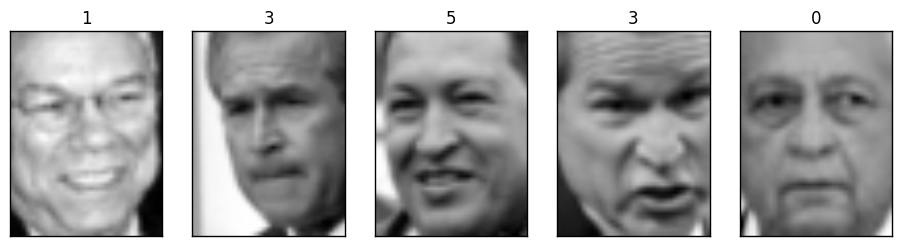

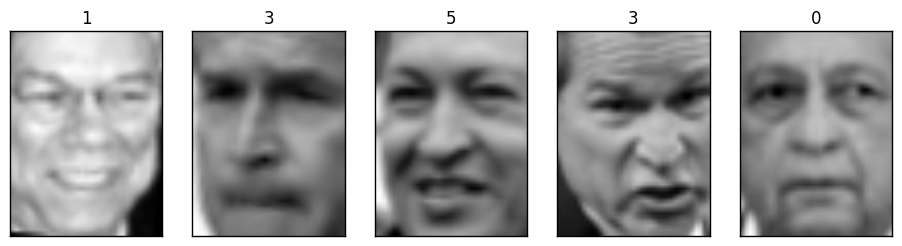

In [29]:
# to see diff between aligned and unaligned
plot_gallery(to_image(X[-10:]), y[-10:], n_row=1, n_col=5)
plot_gallery(to_image(X_images_norm[-10:]), y[-10:], n_row=1, n_col=5)
plt.show()

In [30]:
# validation set
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=3244)
param_grid = {'C': [1e3, 5e3, 1e4, 5e4, 1e5],
              'kernel': ['poly'], 
              'degree': [1, 2, 3],
              'coef0' : [0, 1, 2]}
clf = GridSearchCV(SVC(class_weight='balanced'), param_grid, scoring='f1_micro')
clf = clf.fit(X_train, y_train)
print("Best estimator found by grid search:")
print(clf.best_estimator_)


Best estimator found by grid search:
SVC(C=1000.0, cache_size=200, class_weight='balanced', coef0=0,
  decision_function_shape=None, degree=1, gamma='auto', kernel='poly',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)


In [31]:
# test on test data
print("Predicting people's names on the test set")
t0 = time()
y_pred = clf.predict(X_test)
print("done in %0.3fs" % (time() - t0))

print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred, labels=range(n_classes)))

Predicting people's names on the test set
done in 0.294s
             precision    recall  f1-score   support

          0       0.75      1.00      0.86        12
          1       0.85      0.85      0.85        48
          2       0.68      0.72      0.70        18
          3       0.90      0.84      0.87        98
          4       0.63      0.63      0.63        19
          5       0.91      0.62      0.74        16
          6       0.71      0.87      0.78        31

avg / total       0.82      0.81      0.81       242

[[12  0  0  0  0  0  0]
 [ 1 41  1  2  0  0  3]
 [ 1  1 13  1  1  0  1]
 [ 1  3  4 82  3  1  4]
 [ 1  2  1  2 12  0  1]
 [ 0  0  0  1  3 10  2]
 [ 0  1  0  3  0  0 27]]


In [32]:
clf = clf.best_estimator_
clf.fit(X,y)
print_labels_to_file('poly_fit_to_X.csv', clf.predict(Z))